In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
# keras libraries
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
# text libraries
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import word2vec


2025-08-18 21:51:10.124476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755553870.137326       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755553870.141378       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 21:51:10.157537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'keras.utils.np_utils'

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print(train_df.shape, test_df.shape)


(17621, 3) (1958, 2)


In [4]:
train_df.head()


,id,text,author
0,id06121,So I did not abandon the search until I had be...,EAP
1,id01074,He had promised to spend some hours with me on...,MWS
2,id12145,In the end he give him a funny kind o' thingum...,HPL
3,id18286,What other construction could I possibly put u...,EAP
4,id11118,"I had heard the noise, however faint, and my s...",EAP


In [5]:
# check the class distribution for the author label in train_df?
train_df['author'].value_counts()


author
EAP    7090
MWS    5457
HPL    5074
Name: count, dtype: int64

In [6]:
# compute the character length for the rows and record these
train_df['text_length'] = train_df['text'].str.len()


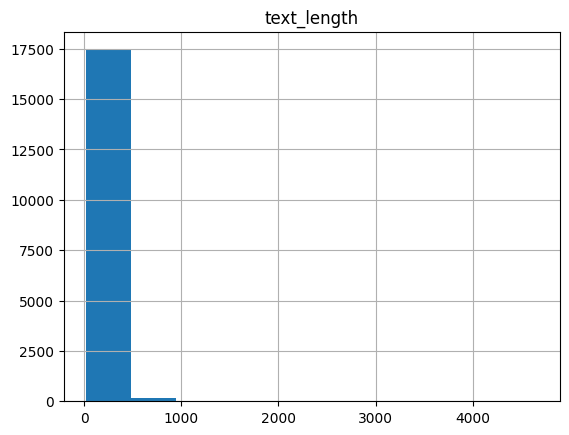

In [7]:
# look at the histogram plot for text length
train_df.hist()
plt.show()


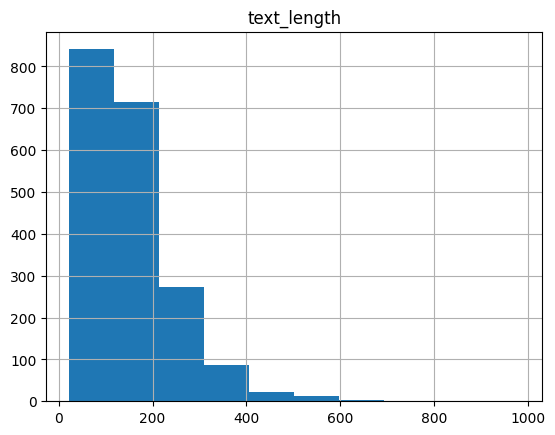

In [8]:
# examine the text characters length in test_df and record these
test_df['text_length'] = test_df['text'].str.len()
test_df.hist()
plt.show()


In [9]:
# convert author labels into one-hot encodings
train_df['author'] = pd.Categorical(train_df['author'])
df_Dummies = pd.get_dummies(train_df['author'], prefix='author')
train_df = pd.concat([train_df, df_Dummies], axis=1)
# Check the conversion
train_df.head()


,id,text,author,text_length,author_EAP,author_HPL,author_MWS
0,id06121,So I did not abandon the search until I had be...,EAP,115,True,False,False
1,id01074,He had promised to spend some hours with me on...,MWS,105,False,False,True
2,id12145,In the end he give him a funny kind o' thingum...,HPL,185,False,True,False
3,id18286,What other construction could I possibly put u...,EAP,267,True,False,False
4,id11118,"I had heard the noise, however faint, and my s...",EAP,73,True,False,False


In [10]:
# helper to clean text and separate into words
def clean_text(text):
    text = text.lower()
    text = re.sub('\W', ' ', text)
    return text


In [11]:
# clean train_df['text']
train_df['text'] = train_df['text'].map(lambda com : clean_text(com))


NameError: name 're' is not defined

In [12]:
# clean test_df['text']
test_df['text'] = test_df['text'].map(lambda com : clean_text(com))


NameError: name 're' is not defined

In [13]:
X = train_df['text']
y = train_df[['author_EAP', 'author_HPL', 'author_MWS']]


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape, X_dev.shape, y_dev.shape)


(14096,) (14096, 3) (3525,) (3525, 3)


In [15]:
# examine the class distribution in y_train and y_dev
print(y_train.sum(axis=0),'\n', y_dev.sum(axis=0))


author_EAP    5696
author_HPL    4050
author_MWS    4350
dtype: int64 
 author_EAP    1394
author_HPL    1024
author_MWS    1107
dtype: int64


In [16]:
# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = CountVectorizer()
# vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b')
# vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\;|\:')
# vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\?|\;|\:|\!|\'')
vect


CountVectorizer()

In [17]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_dtm = X_train_dtm.toarray()
X_train_dtm


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
print(X_train_dtm.shape)


(14096, 22126)


In [19]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_dev_dtm = vect.transform(X_dev)
# examine the document-term matrix from X_test
X_dev_dtm = X_dev_dtm.toarray()
X_dev_dtm


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
print(X_train_dtm.shape, y_train.shape)
print(X_dev_dtm.shape, y_dev.shape)


(14096, 22126) (14096, 3)
(3525, 22126) (3525, 3)


In [21]:
num_input_shape = X_train_dtm.shape[1]
num_class = y_train.shape[1]


In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(num_input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_class, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-18 21:51:17.102833: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [23]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │     1,416,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,643 (5.43 MB)

 Trainable params: 1,424,643 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
             metrics=['accuracy'])


In [25]:
history = model.fit(X_train_dtm, y_train, epochs=20, batch_size=512,
                    validation_data=(X_dev_dtm, y_dev))


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.4851 - loss: 1.0021 - val_accuracy: 0.7716 - val_loss: 0.6538
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8347 - loss: 0.5140 - val_accuracy: 0.8026 - val_loss: 0.5004
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9140 - loss: 0.2938 - val_accuracy: 0.8247 - val_loss: 0.4441
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9501 - loss: 0.1796 - val_accuracy: 0.8026 - val_loss: 0.5047
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9675 - loss: 0.1244 - val_accuracy: 0.8187 - val_loss: 0.5147
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9764 - loss: 0.0813 - val_accuracy: 0.8187 - val_loss: 0.5293
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9878 - loss: 0.0525 - val_accuracy: 0.8193 - val_loss: 0.5926
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9915 - loss: 0.0357 - val_accuracy: 0.8096 - v

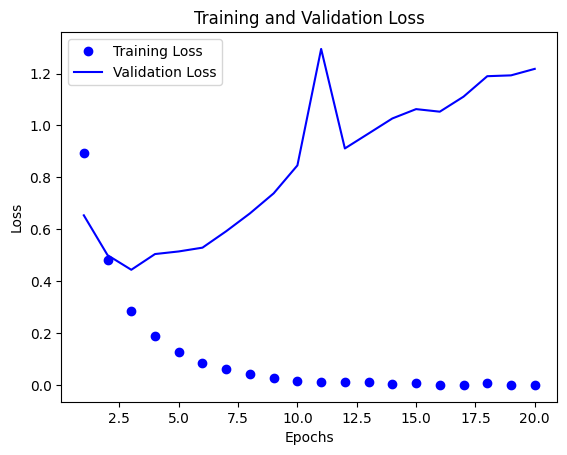

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


KeyError: 'acc'

<Figure size 640x480 with 0 Axes>

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(num_input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_class, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train_dtm, y_train, epochs=3, batch_size=512,
          validation_data=(X_dev_dtm, y_dev))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5198 - loss: 1.0142 - val_accuracy: 0.7589 - val_loss: 0.6770
Epoch 2/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8305 - loss: 0.5286 - val_accuracy: 0.8082 - val_loss: 0.4898
Epoch 3/3
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9099 - loss: 0.3003 - val_accuracy: 0.8170 - val_loss: 0.4595


In [29]:
results = model.evaluate(X_dev_dtm, y_dev)
print(results)


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8211 - loss: 0.4542
[0.459452360868454, 0.8170212507247925]


In [30]:
test = test_df['text']
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_dtm = vect.transform(test)
# examine the document-term matrix from X_test
test_dtm = test_dtm.toarray()
test_dtm


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
print(test_dtm.shape)


(1958, 22126)


In [32]:
# make author (class) predictions for test_dtm
dnn_predictions = model.predict(test_dtm)
print(dnn_predictions.shape)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1958, 3)


In [33]:
print(dnn_predictions[:10])


[[3.90452595e-04 9.99354720e-01 2.54773942e-04]
 [5.75168356e-02 1.02477394e-01 8.40005875e-01]
 [3.87198618e-03 1.95050845e-03 9.94177461e-01]
 [1.05372414e-01 1.28357410e-01 7.66270220e-01]
 [3.27658467e-02 1.07546337e-02 9.56479430e-01]
 [9.13630068e-01 5.17654046e-02 3.46045569e-02]
 [3.23836327e-01 7.39430711e-02 6.02220654e-01]
 [1.37550905e-01 6.49919629e-01 2.12529466e-01]
 [9.80074286e-01 6.22977223e-03 1.36958696e-02]
 [9.24156010e-01 7.14261457e-02 4.41780314e-03]]


In [34]:
result = pd.DataFrame(dnn_predictions, columns=['EAP','HPL','MWS'])
result.insert(0, 'id', test_df['id'])
result.head()


,id,EAP,HPL,MWS
0,id27251,0.000390,0.999355,0.000255
1,id09612,0.057517,0.102477,0.840006
2,id11943,0.003872,0.001951,0.994177
3,id19526,0.105372,0.128357,0.766270
4,id12931,0.032766,0.010755,0.956479


In [35]:
# Generate submission file in csv format
result.to_csv('rhodium_submission_17.csv', index=False, float_format='%.20f')
